 # Kiosk24

Late-night convenience stores, popularly known as Spaeti (German trivialization for late-night stores) have a cult status in Germany and have historically (together with Gas-stations) catered the needs for late-night groceries and other essential suppies when normal supermarkets are closed. Kiosk24 is Germany's largest all-day convenience store chain and is the leader in the country's 4 billion Euro late-night convinience store market. Their USP is that they are, unlike regular shops, open round-the-clock and 24/7.


## Problem statement

Kiosk24 started a pilot project in Berlin offering bicycle based delivery services. It has been gathering data over a period of one year and wants to get an estimated delivery time that it can provide the customers on the basis of a 10 variable strong feature-set that includes among others the distance from the store to their location, total on-duty delivery partners, no. of items ordered and total outstanding orders.

This dataset hence has the required data to train a regression model that will estimate the delivery-time (dependent variable)  based on the feature-set (independent variable).

## Feature Set

store_id: individual id of the store

created_at: the timestamp at which the order was placed

delivered_at: the timestamp when the order was delivered

total_items: total number of items

distinct_items: number of distinct items in the order

subtotal: final bill of the order

total_onshift_runners: no. of delivery partners on duty at order placement

total_busy_runners: number of delivery partners attending to other tasks

total_outstanding_orders: total number of orders to be fulfilled at the moment

store_to_consumer_driving_duration_seconds: approximate travel time from restaurant to customer

## ML Development Lifecycle

**Datapreprocessing**

*Importing libraries*

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
#for reading and handling the data
import pandas as pd
import numpy as np
import os

#for visualizinng and analyzing data
import matplotlib.pyplot as plt
import seaborn as sns

#data preprocessing
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#random forest model training
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

#artificial neural network training
from sklearn import preprocessing
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,LeakyReLU
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsolutePercentageError
from tensorflow.keras.metrics import mean_absolute_percentage_error
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.optimizers import SGD,Adam
from sklearn.metrics import mean_absolute_percentage_error

#Modelbit model deployment
import modelbit

In [3]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

*Loading data*

In [4]:
for dirname, _, filenames in os.walk('C:\Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\Dataset\6F119640
C:\Dataset\Kiosk24 - Kopie.html
C:\Dataset\Kiosk24-mod.ipynb
C:\Dataset\Kiosk24.html
C:\Dataset\Kiosk24.ipynb
C:\Dataset\Kiosk24_data.xlsx
C:\Dataset\Kiosk24_data_mod.xlsx
C:\Dataset\Kiosk24_old.ipynb
C:\Dataset\porter_data.csv
C:\Dataset\.ipynb_checkpoints\Gorillas_use-case-checkpoint.ipynb
C:\Dataset\.ipynb_checkpoints\Kiosk24 - Copy-checkpoint.ipynb
C:\Dataset\.ipynb_checkpoints\Kiosk24-checkpoint.ipynb
C:\Dataset\Backup\Kiosk24 - Copy.ipynb
C:\Dataset\Backup\Kiosk24-sample.html
C:\Dataset\Backup\Kiosk24.html
C:\Dataset\Backup\Kiosk24.ipynb
C:\Dataset\Backup\Kiosk24_data.xlsx
C:\Dataset\Backup\Kiosk24_data_mod.xlsx
C:\Dataset\Backup\porter_data.csv
C:\Dataset\Backup\porter_data.xlsx
C:\Dataset\Backup\porter_data1.xlsx
C:\Dataset\Backup\porter_data2.xlsx
C:\Dataset\Backup\porter_data3.xlsx
C:\Dataset\Backup\porter_data_mod.csv
C:\Dataset\Backup\porter_data_mod.xlsx
C:\Dataset\Backup\temp.docx
C:\Dataset\Backup\New folder\Kiosk24 - Copy.ipynb
C:\Dataset\Backup\New 

In [5]:
df=pd.read_excel('Kiosk24_data.xlsx')

*Understanding data as seen by programming environment*

In [6]:
df.head()

,store_id,created_at,delivered_at,total_items,distinct_items,subtotal,total_onshift_runners,total_busy_runners,total_outstanding_orders,store_to_consumer_driving_duration_seconds
0,1,2015-02-06 22:24:00,2015-02-06 23:11:00,4,4,39.10,33,14,21,861
1,2,2015-02-10 21:49:00,2015-02-10 22:33:00,1,1,21.59,1,2,2,690
2,2,2015-02-16 00:11:00,2015-02-16 01:06:00,4,3,54.22,8,6,18,289
3,1,2015-02-12 03:36:00,2015-02-12 04:35:00,1,1,17.33,5,6,8,795
4,1,2015-01-27 02:12:00,2015-01-27 02:58:00,2,2,41.14,5,5,7,205


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 10 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   store_id                                    175777 non-null  int64         
 1   created_at                                  175777 non-null  datetime64[ns]
 2   delivered_at                                175777 non-null  datetime64[ns]
 3   total_items                                 175777 non-null  int64         
 4   distinct_items                              175777 non-null  int64         
 5   subtotal                                    175777 non-null  float64       
 6   total_onshift_runners                       175777 non-null  int64         
 7   total_busy_runners                          175777 non-null  int64         
 8   total_outstanding_orders                    175777 non-null  int64        

**Feature engineering**

*Preparing the data for further analysis*

In [8]:
df['store_to_consumer_driving_duration_mins']=round(df['store_to_consumer_driving_duration_seconds']/60, 0)

In [9]:
df['time_to_delivery']=df['delivered_at'] - df['created_at']

In [10]:
df['time_to_delivery_mins']=df['time_to_delivery']/pd.Timedelta('60s')

In [11]:
df['created_at_hour']=df['created_at'].dt.hour
df['created_at_day']=df['created_at'].dt.dayofweek

In [12]:
# Define a dictionary to map numeric day of the week to day names
day_names = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

In [13]:
# Create a new column with day names based on the 'created_at_day' column
df['created_at_day_name'] = df['created_at_day'].map(day_names)

*Data Cleaning*

In [14]:
df.drop(['store_to_consumer_driving_duration_seconds','time_to_delivery','created_at','delivered_at'],axis=1,inplace=True)

In [15]:
df.isna().sum()

store_id                                   0
total_items                                0
distinct_items                             0
subtotal                                   0
total_onshift_runners                      0
total_busy_runners                         0
total_outstanding_orders                   0
store_to_consumer_driving_duration_mins    0
time_to_delivery_mins                      0
created_at_hour                            0
created_at_day                             0
created_at_day_name                        0
dtype: int64

In [16]:
df.dropna(inplace=True)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 12 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   store_id                                 175777 non-null  int64  
 1   total_items                              175777 non-null  int64  
 2   distinct_items                           175777 non-null  int64  
 3   subtotal                                 175777 non-null  float64
 4   total_onshift_runners                    175777 non-null  int64  
 5   total_busy_runners                       175777 non-null  int64  
 6   total_outstanding_orders                 175777 non-null  int64  
 7   store_to_consumer_driving_duration_mins  175777 non-null  float64
 8   time_to_delivery_mins                    175777 non-null  float64
 9   created_at_hour                          175777 non-null  int64  
 10  created_at_day                  

In [18]:
df['store_id']=df['store_id'].astype('category').cat.codes

In [19]:
df['created_at_hour']=df['created_at_hour'].astype('category').cat.codes

In [20]:
df['created_at_day']=df['created_at_day'].astype('category').cat.codes

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 12 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   store_id                                 175777 non-null  int8   
 1   total_items                              175777 non-null  int64  
 2   distinct_items                           175777 non-null  int64  
 3   subtotal                                 175777 non-null  float64
 4   total_onshift_runners                    175777 non-null  int64  
 5   total_busy_runners                       175777 non-null  int64  
 6   total_outstanding_orders                 175777 non-null  int64  
 7   store_to_consumer_driving_duration_mins  175777 non-null  float64
 8   time_to_delivery_mins                    175777 non-null  float64
 9   created_at_hour                          175777 non-null  int8   
 10  created_at_day                  

In [22]:
df.head()

,store_id,total_items,distinct_items,subtotal,total_onshift_runners,total_busy_runners,total_outstanding_orders,store_to_consumer_driving_duration_mins,time_to_delivery_mins,created_at_hour,created_at_day,created_at_day_name
0,0,4,4,39.10,33,14,21,14.0,47.0,17,4,Friday
1,1,1,1,21.59,1,2,2,12.0,44.0,16,1,Tuesday
2,1,4,3,54.22,8,6,18,5.0,55.0,0,0,Monday
3,0,1,1,17.33,5,6,8,13.0,59.0,3,3,Thursday
4,0,2,2,41.14,5,5,7,3.0,46.0,2,1,Tuesday


In [23]:
#df.to_excel("Kiosk24_data_mod.xlsx", index=False)

*Data Visualization*

<Axes: >

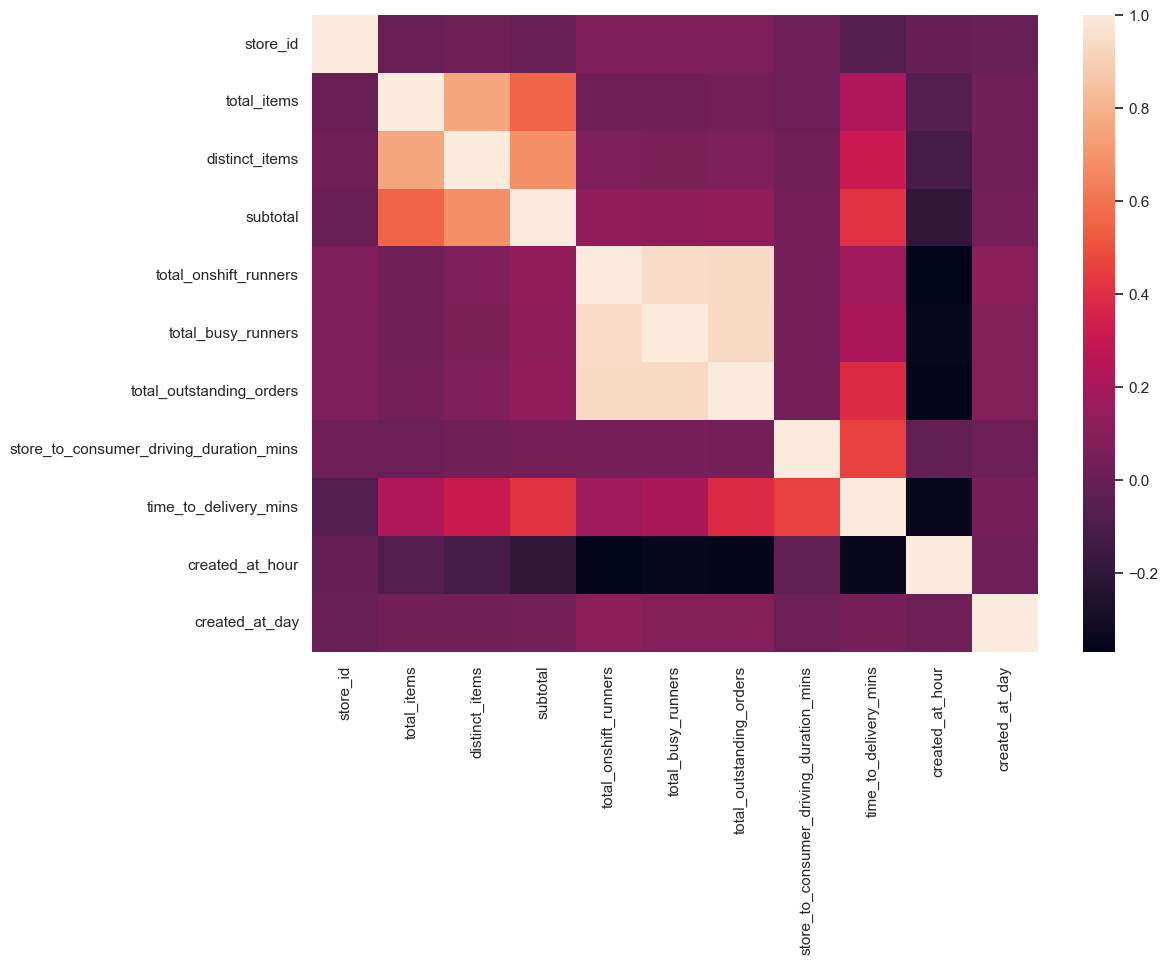

In [24]:
sns.heatmap(df[[col for col in df.columns if col != 'created_at_day_name']].corr())

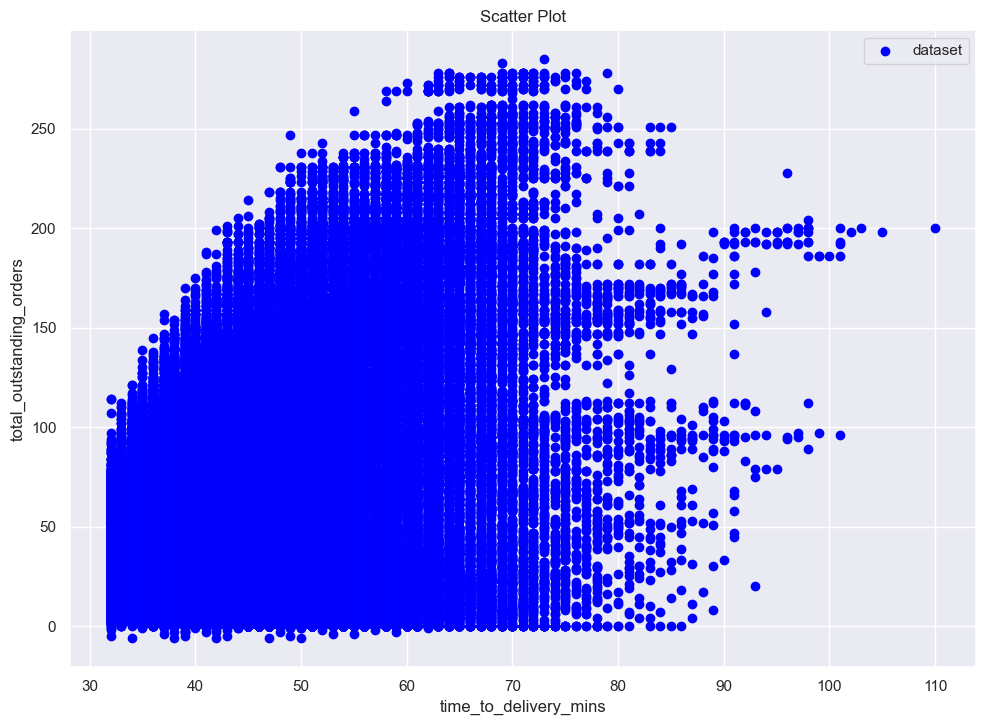

In [25]:
plt.scatter(df.time_to_delivery_mins, df.total_outstanding_orders, label='dataset', color='blue')

plt.xlabel('time_to_delivery_mins')
plt.ylabel('total_outstanding_orders')
plt.title('Scatter Plot')

# Add a legend to distinguish the two DataFrames
plt.legend()

<Axes: xlabel='total_items', ylabel='subtotal'>

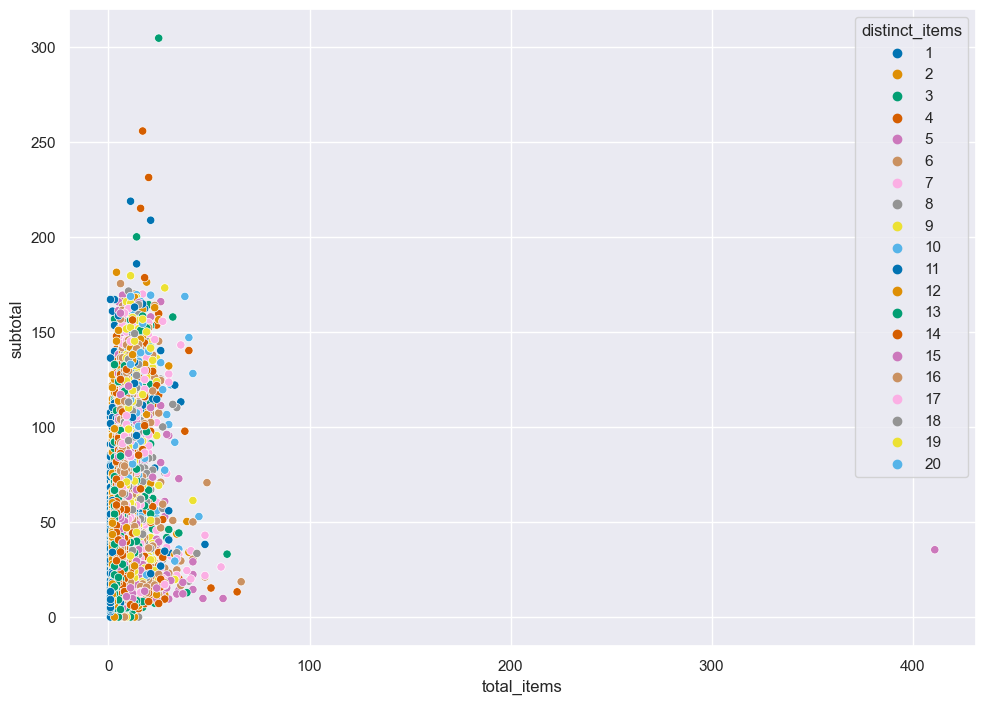

In [26]:
sns.scatterplot(x='total_items',y='subtotal',hue='distinct_items',palette='colorblind',data=df)

In [27]:
model1=LocalOutlierFactor()
#model1.fit(df)
df['lof_anomaly_score']=model1.fit_predict(df[[col for col in df.columns if col != 'created_at_day_name']])

In [28]:
print("number of outliers : ",(len(df.loc[(df['lof_anomaly_score'] == -1)])))
df_anomaly=df.loc[(df['lof_anomaly_score'] == -1)]
df=df.loc[(df['lof_anomaly_score'] == 1)]

number of outliers :  801


In [29]:
df.drop(['lof_anomaly_score'],axis=1,inplace=True)

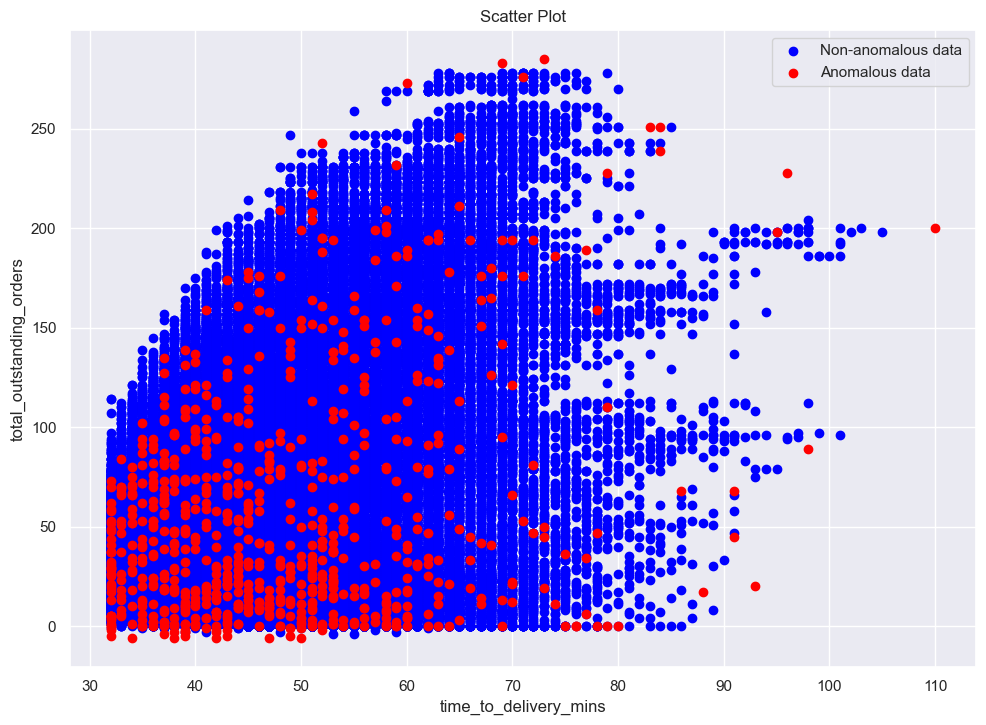

In [30]:
plt.scatter(df.time_to_delivery_mins, df.total_outstanding_orders, label='Non-anomalous data', color='blue')
plt.scatter(df_anomaly.time_to_delivery_mins, df_anomaly.total_outstanding_orders, label='Anomalous data', color='red')

plt.xlabel('time_to_delivery_mins')
plt.ylabel('total_outstanding_orders')
plt.title('Scatter Plot')

# Add a legend to distinguish the two DataFrames
plt.legend()

<Axes: xlabel='time_to_delivery_mins', ylabel='total_outstanding_orders'>

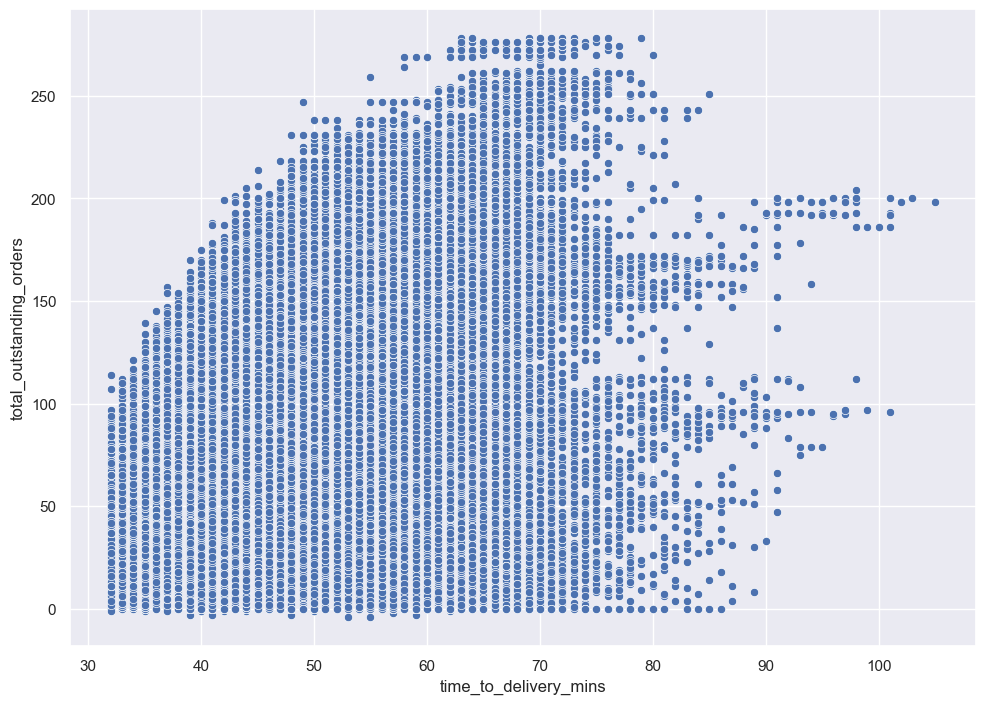

In [31]:
sns.scatterplot(x='time_to_delivery_mins',y='total_outstanding_orders',data=df)

<Axes: xlabel='created_at_day', ylabel='count'>

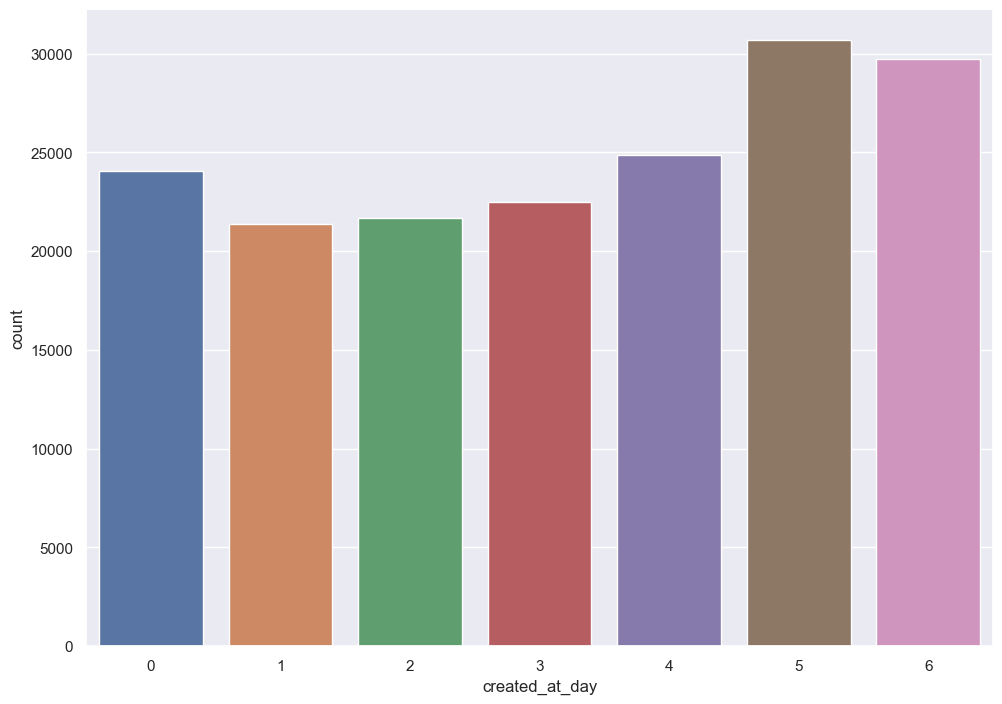

In [32]:
sns.countplot(x=df.created_at_day)

In [33]:
# Specify the order of the x-axis categories
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

<Axes: xlabel='created_at_day_name', ylabel='count'>

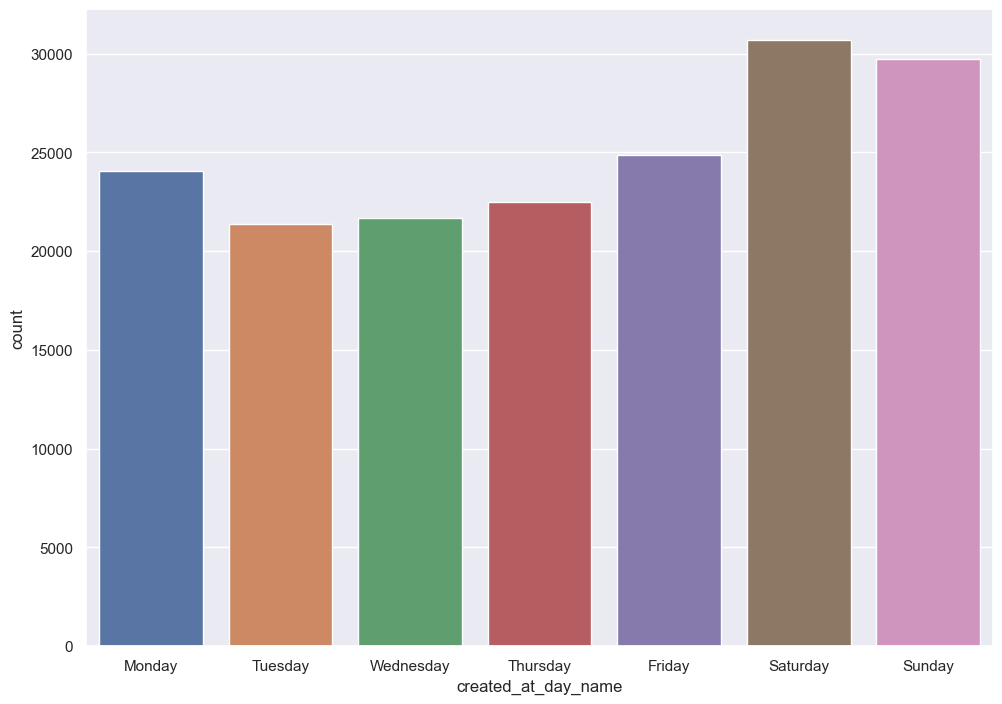

In [34]:
sns.countplot(x=df.created_at_day_name, order=order)

<Axes: xlabel='created_at_hour', ylabel='count'>

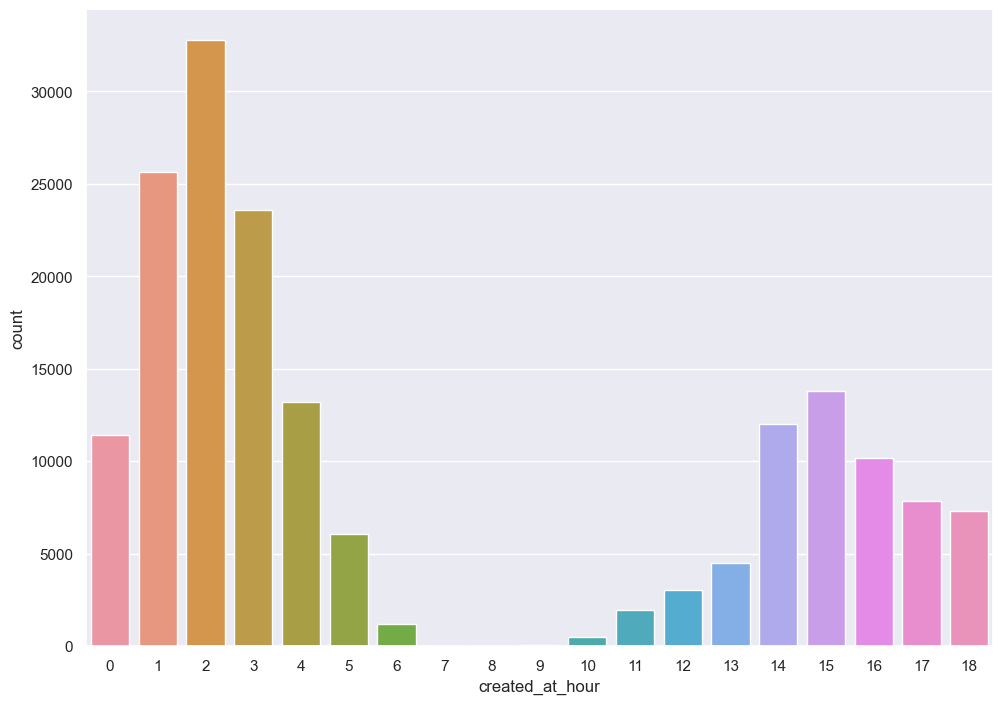

In [35]:
sns.countplot(x=df.created_at_hour)

**Data Splitting and Modelling**

In [36]:
y=df['time_to_delivery_mins']
x=df.drop(['time_to_delivery_mins', 'created_at_day_name'],axis=1)
X_train_RF,X_test_RF,y_train_RF,y_test_RF=train_test_split(x,y,test_size=0.2,random_state=42)

In [37]:
x.head()

,store_id,total_items,distinct_items,subtotal,total_onshift_runners,total_busy_runners,total_outstanding_orders,store_to_consumer_driving_duration_mins,created_at_hour,created_at_day
0,0,4,4,39.10,33,14,21,14.0,17,4
1,1,1,1,21.59,1,2,2,12.0,16,1
2,1,4,3,54.22,8,6,18,5.0,0,0
3,0,1,1,17.33,5,6,8,13.0,3,3
4,0,2,2,41.14,5,5,7,3.0,2,1


In [38]:
y.head()

0    47.0
1    44.0
2    55.0
3    59.0
4    46.0
Name: time_to_delivery_mins, dtype: float64

***Supervised Learning - Random Forest Regression Model***

In [39]:
RF_regressor=RandomForestRegressor()
RF_regressor.fit(X_train_RF,y_train_RF)

RandomForestRegressor()

In [40]:
prediction=RF_regressor.predict(X_test_RF)
mse=mean_squared_error(y_test_RF,prediction)
rmse=mse**.5
print("mse : ",mse)
print("rmse : ",rmse)
mae=mean_absolute_error(y_test_RF,prediction)
print("mase : ",mae)

mse :  3.943310557312738
rmse :  1.9857770663679088
mase :  1.4771390907260151


In [41]:
r2_score(y_test_RF,prediction)

0.9549897778553431

In [42]:
def MAPE(Y_actual,Y_Predicted):
    mape=np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [43]:
print("mape : ",MAPE(y_test_RF,prediction))

mape :  3.2368716789171894


Text(0.5, 0, 'Random Forest Feature Importance')

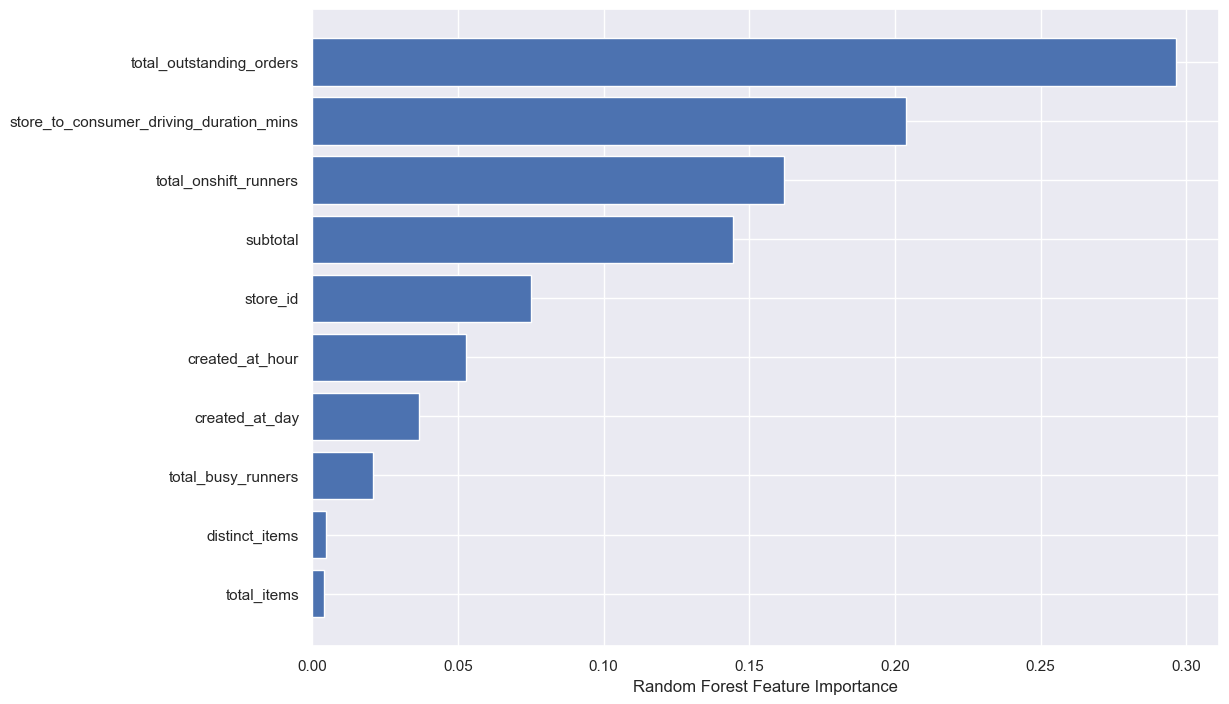

In [44]:
sorted_idx=RF_regressor.feature_importances_.argsort()
plt.barh(x.columns[sorted_idx],RF_regressor.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

***Supervised Learning - Neural Networks***

***Scaling data before feeding to neural network***

In [45]:
#scaler=preprocessing.MinMaxScaler()
#x_scaled=scaler.fit_transform(x)
#X_train_ANN,X_test_ANN,y_train_ANN,y_test_ANN=train_test_split(x_scaled,y,test_size=0.2,random_state=42)

In [46]:
#X_train_ANN[0:1]

In [47]:
#x.iloc[0]

In [48]:
#x_scaled[0:1]

In [49]:
#original_x = scaler.inverse_transform(x_scaled[0:1])

In [50]:
#original_x

In [51]:
#ANN_model=Sequential()
#ANN_model.add(Dense(14,kernel_initializer='normal',activation='relu'))
#ANN_model.add(Dense(512,activation='relu'))
#ANN_model.add(Dense(1024,activation='relu'))
#ANN_model.add(Dense(256,activation='relu'))
#ANN_model.add(Dense(1,activation='linear'))

In [52]:
#adam=Adam(learning_rate=0.01)
#ANN_model.compile(loss='mse',optimizer=adam,metrics=['mse','mae'])
#history=ANN_model.fit(X_train_ANN,y_train_ANN,epochs=30,batch_size=512,verbose=1,validation_split=0.2)

***Scaling data before feeding to neural network and creating a custom TensorFlow layer that performs the scaling operation***

In [53]:
import tensorflow as tf
from sklearn import preprocessing

class MinMaxScalerLayer(tf.keras.layers.Layer):
    def __init__(self, scaler, **kwargs):
        super(MinMaxScalerLayer, self).__init__(**kwargs)
        self.min_ = tf.Variable(initial_value=scaler.data_min_, trainable=False, dtype=tf.float32)
        self.scale_ = tf.Variable(initial_value=scaler.scale_, trainable=False, dtype=tf.float32)

    def call(self, inputs):
        return (inputs - self.min_) * self.scale_


In [54]:
# Train-test split without scaling
X_train_ANN, X_test_ANN, y_train_ANN, y_test_ANN = train_test_split(x, y, test_size=0.2, random_state=42)

# Initialize the MinMaxScaler and fit on the training data
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train_ANN)

# Create a new sequential model
ANN_model = tf.keras.Sequential()

# Add the scaler layer to the model
ANN_model.add(MinMaxScalerLayer(scaler, input_shape=(X_train_ANN.shape[1],)))

# Rest of your model architecture
ANN_model.add(Dense(14, kernel_initializer='normal', activation='relu'))
ANN_model.add(Dense(512, activation='relu'))
ANN_model.add(Dense(1024, activation='relu'))
ANN_model.add(Dense(256, activation='relu'))
ANN_model.add(Dense(1, activation='linear'))

# Compile and train the model
adam = Adam(learning_rate=0.01)
ANN_model.compile(loss='mse', optimizer=adam, metrics=['mse', 'mae'])
history = ANN_model.fit(X_train_ANN, y_train_ANN, epochs=30, batch_size=512, verbose=1, validation_split=0.2)

Epoch 1/30
219/219 [==============================] - 9s 35ms/step - loss: 77.5232 - mse: 77.5232 - mae: 5.3626 - val_loss: 9.5372 - val_mse: 9.5372 - val_mae: 2.4740
Epoch 2/30
219/219 [==============================] - 8s 34ms/step - loss: 4.8078 - mse: 4.8078 - mae: 1.6991 - val_loss: 5.1995 - val_mse: 5.1995 - val_mae: 1.7971
Epoch 3/30
219/219 [==============================] - 8s 37ms/step - loss: 3.9158 - mse: 3.9158 - mae: 1.5540 - val_loss: 3.6128 - val_mse: 3.6128 - val_mae: 1.5046
Epoch 4/30
219/219 [==============================] - 8s 36ms/step - loss: 3.3870 - mse: 3.3870 - mae: 1.4512 - val_loss: 2.1455 - val_mse: 2.1455 - val_mae: 1.1653
Epoch 5/30
219/219 [==============================] - 8s 37ms/step - loss: 3.1368 - mse: 3.1368 - mae: 1.4040 - val_loss: 1.9234 - val_mse: 1.9234 - val_mae: 1.1018
Epoch 6/30
219/219 [==============================] - 8s 35ms/step - loss: 3.1702 - mse: 3.1702 - mae: 1.4083 - val_loss: 1.8579 - val_mse: 1.8579 - val_mae: 1.0769
Epoch 7/

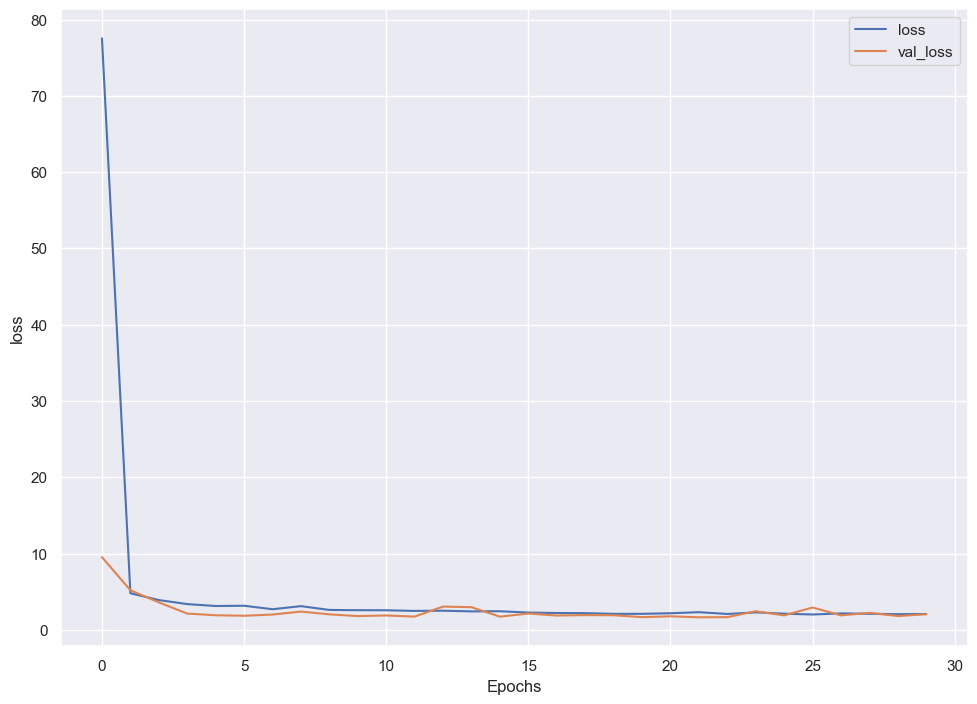

In [55]:
def plot_history(history,key):
    plt.plot(history.history[key])
    plt.plot(history.history['val_'+key])
    plt.xlabel("Epochs")
    plt.ylabel(key)
    plt.legend([key,'val_'+key])
    plt.show()
#plot the history
plot_history(history,'loss')

In [56]:
z= ANN_model.predict(X_test_ANN)

1094/1094 [==============================] - 4s 3ms/step


In [57]:
r2_score(y_test_ANN, z)

0.9760301932866675

In [58]:
mse = mean_squared_error(y_test_ANN, z)
rmse = mse**.5
print("mse : ",mse)
print("rmse : ",rmse)
print("errors for neural net")
mae = mean_absolute_error(y_test_ANN, z)
print("mae : ",mae)

mse :  2.0999761246601665
rmse :  1.449129436820661
errors for neural net
mae :  1.1421026313682328


In [59]:
mean_absolute_percentage_error(y_test_ANN, z)

0.025826775221543977

**Model Deployment**

In [60]:
import joblib
joblib.dump(RF_regressor, 'RF.joblib')

['RF.joblib']

In [61]:
#joblib.dump(ANN_model, 'ANN.joblib')

In [62]:
joblib.load("RF.joblib").predict(x.iloc[0:1])

array([46.66])

In [63]:
RF_regressor.predict(x.iloc[0:1])

array([46.66])

***Saving the model in SavedModel format***

In [64]:
# Saving the model in SavedModel format
#ANN_model.save("ANN")
#ANN_model.save("ANN.keras")
# Save the MinMaxScaler using joblib
#joblib.dump(scaler, "scaler.joblib")

In [65]:
# Saving the model in SavedModel format
ANN_model.save("ANN_scaled")

INFO:tensorflow:Assets written to: ANN_scaled\assets


***Loading the model saved before***

In [66]:
from tensorflow.keras.models import load_model

# Load the model from the SavedModel format
ANN_loaded_model = load_model("ANN.keras")
ANN_loaded_model_scaled = load_model("ANN_scaled")
#options = LoadOptions(experimental_io_device="/job:localhost")
#ANN_loaded_model = tf.keras.models.load_model("AN", options=options)

# Load the MinMaxScaler using joblib
loaded_scaler = joblib.load("scaler.joblib")

In [67]:
ANN_loaded_model.predict(loaded_scaler.transform(x.iloc[0:1])).flatten()

1/1 [==============================] - 0s 82ms/step


array([45.37019], dtype=float32)

In [68]:
ANN_loaded_model_scaled.predict(x.iloc[0:1]).flatten()

1/1 [==============================] - 0s 107ms/step


array([46.839478], dtype=float32)

***Defining predictor functions***

In [69]:
def RF_regressor_predictor(sample):
    """
    Predict the target value for a single sample using a regression model.

    Args:
        model (object): The trained regression model (e.g., RandomForestRegressor).
        sample (array-like): An array-like object containing feature values for a single data point.

    Returns:
        float: The predicted target value.
    """
    # Reshape the sample into a 2D array to match the model's input requirements
    
    # Use the model to make the prediction
    
    return RF_regressor.predict(sample)  # Extract and return the predicted value

In [70]:
def ANN_regressor_predictor(sample):
    """
    Predict the target value for a single sample using a regression model.

    Args:
        model (object): The trained regression model (e.g., RandomForestRegressor).
        sample (array-like): An array-like object containing feature values for a single data point.

    Returns:
        float: The predicted target value.
    """
    # Reshape the sample into a 2D array to match the model's input requirements

    # Use the model to make the prediction

    # Load the MinMaxScaler using joblib

   
    return ANN_loaded_model.predict(loaded_scaler.transform(sample)).flatten()  # Extract and return the predicted value

In [71]:
def ANN_regressor_predictor_2(sample):
    """
    Predict the target value for a single sample using a regression model.

    Args:
        model (object): The trained regression model (e.g., RandomForestRegressor).
        sample (array-like): An array-like object containing feature values for a single data point.

    Returns:
        float: The predicted target value.
    """
    # Reshape the sample into a 2D array to match the model's input requirements

    # Use the model to make the prediction


    # Load the model from the SavedModel format
    ANN_loaded_model = load_model("ANN.keras")

    # Load the MinMaxScaler using joblib
    loaded_scaler = joblib.load("scaler.joblib")
   
    return ANN_loaded_model.predict(loaded_scaler.transform(sample)).flatten()  # Extract and return the predicted value

In [72]:
def ANN_regressor_predictor_scaled(sample):
    """
    Predict the target value for a single sample using a regression model.

    Args:
        model (object): The trained regression model (e.g., RandomForestRegressor).
        sample (array-like): An array-like object containing feature values for a single data point.

    Returns:
        float: The predicted target value.
    """
    # Reshape the sample into a 2D array to match the model's input requirements

    # Use the model to make the prediction

    # Load the MinMaxScaler using joblib

   
    return ANN_loaded_model_scaled.predict(sample).flatten()  # Extract and return the predicted value

***Testing predictor functions***

In [73]:
example_input = x.iloc[0:1]

In [74]:
example_input

,store_id,total_items,distinct_items,subtotal,total_onshift_runners,total_busy_runners,total_outstanding_orders,store_to_consumer_driving_duration_mins,created_at_hour,created_at_day
0,0,4,4,39.1,33,14,21,14.0,17,4


In [75]:
RF_regressor_predictor(example_input)

array([46.66])

In [76]:
ANN_regressor_predictor(example_input)

1/1 [==============================] - 0s 29ms/step


array([45.37019], dtype=float32)

In [77]:
ANN_regressor_predictor_scaled(example_input)

1/1 [==============================] - 0s 26ms/step


array([46.839478], dtype=float32)

***Deploying API***

In [78]:
import modelbit
mb = modelbit.login()

In [79]:
#my_model = pickle.load("my_model.pkl") # load your file
#def my_inference_function(...):
 #return my_model.predict(...) # call your model 
#mb.deploy(my_inference_function) # modelbit will capture my_model automatically

In [80]:
#def my_inference_function(...):
 #my_model = pickle.load("my_model.pkl")
 #return my_model.predict(...) 

#mb.deploy(my_inference_function, extra_files=["my_model.pkl"])

In [82]:
mb.deploy(RF_regressor_predictor,
          dataframe_mode=True,
          example_dataframe=example_input)

Uploading 'RF_regressor': 100%|██████████| 143M/143M [00:35<00:00, 4.08MB/s] 


In [83]:
mb.deploy(ANN_regressor_predictor,
          dataframe_mode=True,
          example_dataframe=example_input, python_packages=["tensorflow==2.13.0"])

Uploading 'ANN_loaded_model': 100%|██████████| 2.94M/2.94M [00:06<00:00, 426kB/s]
Uploading 'loaded_scaler': 100%|██████████| 672/672 [00:01<00:00, 548B/s]


In [84]:
mb.deploy(ANN_regressor_predictor_2,
          dataframe_mode=True,
          example_dataframe=example_input, extra_files=["scaler.joblib", "ANN.keras"], python_packages=["tensorflow==2.13.0"])

Uploading 'scaler.joblib': 100%|██████████| 912/912 [00:01<00:00, 726B/s]
Uploading 'ANN.keras': 100%|██████████| 6.50M/6.50M [00:13<00:00, 491kB/s]


In [ ]:
mb.deploy(ANN_regressor_predictor_scaled,
          dataframe_mode=True,
          example_dataframe=example_input, python_packages=["tensorflow==2.13.0"])

***Testing the API***

In [86]:
import requests, json

requests.post(
    "https://vishwarathtomar.app.modelbit.com/v1/RF_regressor_predictor/latest",
    headers={"Content-Type":"application/json"},
    data=json.dumps({"data": {
        "store_id": 0,
        "total_items": 4,
        "distinct_items": 4,
        "subtotal": 39.1,
        "total_onshift_runners": 33,
        "total_busy_runners": 14,
        "total_outstanding_orders":21,
        "store_to_consumer_driving_duration_mins": 14,
        "created_at_hour": 17,
        "created_at_day": 4
    }})).json()

{'data': 46.66}

In [ ]:
import requests, json

requests.post(
    "https://vishwarathtomar.app.modelbit.com/v1/ANN_regressor_predictor_2/latest",
    headers={"Content-Type":"application/json"},
    data=json.dumps({"data": {
        "store_id": 0,
        "total_items": 4,
        "distinct_items": 4,
        "subtotal": 39.1,
        "total_onshift_runners": 33,
        "total_busy_runners": 14,
        "total_outstanding_orders":21,
        "store_to_consumer_driving_duration_mins": 14,
        "created_at_hour": 17,
        "created_at_day": 4
    }})).json()

In [ ]:
import requests, json

requests.post(
    "http://localhost:8605/v1/models/my_model:predict",
    headers={"Content-Type":"application/json"},
    data=json.dumps({"data": {
        "store_id": 0,
        "total_items": 4,
        "distinct_items": 4,
        "subtotal": 39.1,
        "total_onshift_runners": 33,
        "total_busy_runners": 14,
        "total_outstanding_orders":21,
        "store_to_consumer_driving_duration_mins": 14,
        "created_at_hour": 17,
        "created_at_day": 4
    }})).json()